In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np

In [2]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
    
    @property
    def metrics(self): 
        return [self.loss_tracker]

    
    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)
        
        with tf.GradientTape() as tape:
            #Compute the Loss Value
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                y_pred = self(x, training=True)
            dy = tape2.gradient(y_pred, x)
            x_o = tf.zeros((batch_size,1))
            y_o = self(x_o, training=True)
            eq = x*dy + y_pred - ((x**2) *  tf.math.cos(x)) 
            ic = y_o
            loss = keras.losses.mean_squared_error(0., eq) + keras.losses.mean_squared_error(0.,ic)
            
        #Apply grads
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
        self.loss_tracker.update_state(loss)
        #Return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result()}


In [3]:
model = ODEsolver()

model.add(Dense(10, activation='tanh', input_shape=(1,)))
model.add(Dense(1, activation='tanh'))
model.add(Dense(1, activation='linear'))

model.summary()

model.compile(optimizer=Adam(), metrics=['loss'])

a=tf.linspace(-5,5,100)
history = model.fit(a,epochs=1000,verbose=1)

a_testv = tf.linspace(-5,5,100)
x=model.predict(a_testv)

Model: "od_esolver"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 4ms/step - loss: 48.2071
Epoch 2/1000
4/4 [==============================] - 0s 4ms/step - loss: 33.2334
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 42.9241
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 40.1265
Epoc

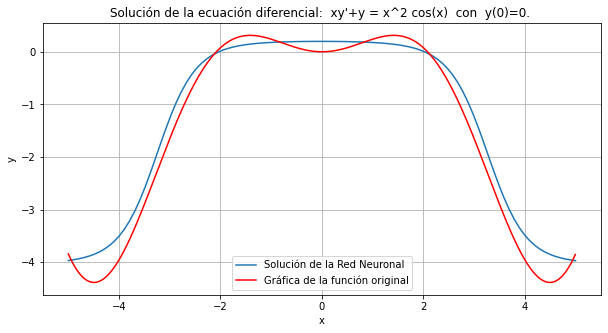

In [4]:
a_1 =np.arange(-5,5, 0.005)  
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(a_testv,x, label='Solución de la Red Neuronal')

plt.plot(a_1,((a_1**2.) - 2.)* np.sin(a_1)/a_1+(2.*np.cos(a_1)), label='Gráfica de la función original', color='red')


plt.title( "Solución de la ecuación diferencial:  xy'+y = x^2 cos(x)  con  y(0)=0. ")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(which='both')
plt.legend()
plt.show()